<a href="https://colab.research.google.com/github/Anish7-anish/BTEC-State-Detection/blob/main/HPW_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install schedule

In [2]:
import requests
import numpy as np
import pandas as pd
import tensorflow as tf
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, InputLayer
import json
from dateutil import tz
from datetime import timedelta
import matplotlib.pyplot as plt
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
from datetime import datetime, timedelta
import pytz


In [3]:
np.random.seed(42)
tf.random.set_seed(42)

def get_bearer_token(auth, password, name, role, url):
    # Form and send the GraphQL request for authentication
    auth_query = f"""
        mutation authRequest {{
            authenticationRequest(
                input: {{authenticator: "{auth}", role: "{role}", userName: "{name}"}}
            ) {{
                jwtRequest {{
                    challenge, message
                }}
            }}
        }}
    """
    auth_response = requests.post(url, json={'query': auth_query})
    auth_response.raise_for_status()
    jwt_request = auth_response.json()['data']['authenticationRequest']['jwtRequest']
    if jwt_request['challenge'] is None:
        raise requests.exceptions.HTTPError(jwt_request['message'])

    # Form and send the GraphQL request for the token validation
    validation_query = f"""
        mutation authValidation {{
            authenticationValidation(
                input: {{authenticator: "{auth}", signedChallenge: "{jwt_request['challenge']}|{password}"}}
            ) {{
                jwtClaim
            }}
        }}
    """
    validation_response = requests.post(url, json={'query': validation_query})
    validation_response.raise_for_status()
    jwt_claim = validation_response.json()['data']['authenticationValidation']['jwtClaim']
    return f"Bearer {jwt_claim}"

In [4]:
def perform_graphql_request(query, url, auth, password, name, role, current_token=None):
    # If no token was provided or if the token is expired, get a new one
    if current_token is None:
        current_token = get_bearer_token(auth, password, name, role, url)
    headers = {"Authorization": current_token}

    # Perform the request with the token
    response = requests.post(url, json={'query': query}, headers=headers)
    if response.status_code == 401:  # Unauthorized, token has expired
        current_token = get_bearer_token(auth, password, name, role, url)
        headers = {"Authorization": current_token}
        response = requests.post(url, json={'query': query}, headers=headers)

    response.raise_for_status()  # Raises an HTTPError for bad responses
    return response.json()

In [5]:
def preprocess_realtime_data(data, sequence_length):
    # Convert string values to 'Off' and 'On' for RO_Skid_Running column
    for ts, entry in data.items():
        if entry["RO_Skid_Running"] == "None":
            entry["RO_Skid_Running"] = np.nan
        elif entry["RO_Skid_Running"] == "0":
            entry["RO_Skid_Running"] = "Off"
        elif entry["RO_Skid_Running"] == "1":
            entry["RO_Skid_Running"] = "On"

    # Convert 'None' or NaN values to np.nan for Level_PV column
    for ts, entry in data.items():
        if entry["Level_PV"] is None or np.isnan(entry.get("Level_PV", np.nan)):
            entry["Level_PV"] = np.nan

    # Convert data to DataFrame for better visualization
    df = pd.DataFrame.from_dict(data, orient='index')

    # Forward fill the missing values for "Level_PV" and "RO_Skid_Running"
    df['Level_PV'] = df['Level_PV'].fillna(method='ffill')
    df['RO_Skid_Running'] = df['RO_Skid_Running'].fillna(method='ffill')

    # After forward fill, if there are still NaNs at the start, fill with the first non-NaN value
    df['Level_PV'].fillna(method='bfill', inplace=True)
    df['RO_Skid_Running'].fillna(method='bfill', inplace=True)

    # Create sequences of the same length as model input sequence length
    X_realtime = []
    timestamps = list(df.index)  # Keep track of timestamps to maintain the integrity of sequences

    for i in range(len(df) - sequence_length + 1):
        sequence = [df['Level_PV'].iloc[j] for j in range(i, i + sequence_length)]
        X_realtime.append(sequence)

    return np.array(X_realtime), df

In [6]:
def save_state_info(state_info, file_path='state_info.json'):
    with open(file_path, 'w') as file:
        json.dump(state_info, file)

def load_state_info(file_path='state_info.json'):
    try:
        with open(file_path, 'r') as file:
            return json.load(file)
    except FileNotFoundError:
        return {"current_state": "normal", "last_state_change_time": datetime.now(pytz.utc).strftime('%Y-%m-%d %H:%M:%S+00:00')}


In [7]:
# def train_and_save_model(X_train, X_test, sequence_length):
#     model = Sequential([
#         InputLayer(input_shape=(sequence_length, 1)),
#         LSTM(50, activation='relu'),
#         RepeatVector(sequence_length),
#         LSTM(50, activation='relu', return_sequences=True),
#         TimeDistributed(Dense(1))
#     ])
#     model.compile(optimizer='adam', loss='mean_squared_error')
#     model.fit(X_train, X_train, epochs=100, batch_size=32, validation_data=(X_test, X_test))
#     model.save('lstm_model.h5')

In [8]:
import numpy as np

def modified_z_scores(observations):
    median_y = np.median(observations)
    median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in observations])
    modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y if median_absolute_deviation_y else 0 for y in observations]
    return modified_z_scores

def dynamic_thresholding(data, window_size=50, threshold_factor=3.5):
    alerts = []
    for i in range(len(data)):
        if i < window_size:
            window_data = data[:i+1]
        else:
            window_data = data[i-window_size:i]

        scores = modified_z_scores(window_data)
        if np.abs(scores[-1]) > threshold_factor:
            alerts.append(i)  # index of the anomaly
    return alerts


In [9]:
from dateutil import parser
def preprocess_data(data):
    processed_data = {}
    prev_stringvalue = None
    for entry in data:
        ts_str = entry["ts"]
        ts = parser.isoparse(ts_str)
        level_pv = entry["floatvalue"]  # Rename "floatvalue" to "Level_PV"
        ro_skid_running = entry["stringvalue"]  # Rename "stringvalue" to "RO_Skid_Running"
        if ro_skid_running is None:
            last_ts = max(processed_data.keys()) if processed_data else None
            if last_ts and (ts - last_ts) <= timedelta(minutes=10):
                ro_skid_running = prev_stringvalue
        else:
            prev_stringvalue = ro_skid_running
        processed_data[ts] = {'Level_PV': level_pv, 'RO_Skid_Running': ro_skid_running}
    return processed_data

In [10]:
def filter_anomalies(anomalies, window=3):
    # Create an array to hold the filtered anomalies
    filtered_anomalies = []
    for index in anomalies:
        # Check if the next `window` points are also anomalies
        if all(i in anomalies for i in range(index, index + window)):
            filtered_anomalies.append(index)

    # Return the unique values to avoid duplicate indices
    return np.unique(filtered_anomalies)

def adaptive_percentile_threshold(errors, window_size=100, percentile=95):
    # Calculate the rolling percentile
    if len(errors) < window_size:
        # Not enough data to fill the window, use available data
        return np.percentile(errors, percentile)
    else:
        # Use the last `window_size` errors to calculate the percentile
        return np.percentile(errors[-window_size:], percentile)

# Usage in your existing code


In [11]:
def generate_query_timestamps(days=6):
    """
    Generates query timestamps for the past 'hours' hours until now.

    :param hours: The number of hours to look back from the current time.
    :return: A tuple containing the start and end timestamps as strings.
    """
    # Assuming UTC time zone. Change 'utc' to another time zone if needed
    utc_zone = pytz.utc
    end_time = datetime.now(utc_zone)
    start_time = end_time - timedelta(days=days)

    # Format timestamps as required for your GraphQL query
    time_format = "%Y-%m-%d %H:%M:%S+00"
    return start_time.strftime(time_format), end_time.strftime(time_format)


def generate_query_timestamps_training(days=6, training_days=22):
    """
    Generates query timestamps for the past 'days' days until now, and adjusts the start time
    to consider the training data period.

    :param days: The total number of days to look back from the current time.
    :param training_days: The number of days to use for training data.
    :return: A tuple containing the start and end timestamps as strings.
    """
    # Assuming UTC time zone. Change 'utc' to another time zone if needed
    utc_zone = pytz.utc
    end_time = datetime.now(utc_zone) - timedelta(days=days)
    start_time = end_time - timedelta(days=training_days)

    # Adjust start time to consider training data period
    time_format = "%Y-%m-%d %H:%M:%S+00"
    return start_time.strftime(time_format), end_time.strftime(time_format)

In [12]:
# def send_email(subject, message, sender_email='newvalo49@gmail.com', receiver_email='atoorpu@ncsu.edu', password='kntu yxlv bzrg sxmp'):
#     msg = MIMEMultipart()
#     msg['From'] = sender_email
#     msg['To'] = receiver_email
#     msg['Subject'] = subject
#     msg.attach(MIMEText(message, 'plain'))

#     try:
#         server = smtplib.SMTP('smtp.gmail.com', 587)
#         server.starttls()
#         server.login(sender_email, password)
#         text = msg.as_string()
#         server.sendmail(sender_email, receiver_email, text)
#         print('Email sent successfully!')
#     except Exception as e:
#         print(f"Error sending email: {e}")
#     finally:
#         server.quit()


import io
import matplotlib.pyplot as plt
from email.mime.image import MIMEImage

def send_email(subject, message, original_plot_buffer=None, zoomed_plot_buffer=None):

    sender_email = 'newvalo49@gmail.com'
    receiver_email = 'atoorpu@ncsu.edu'
    password = 'kntu yxlv bzrg sxmp'
    msg = MIMEMultipart()
    msg['From'] = sender_email
    msg['To'] = receiver_email
    msg['Subject'] = subject
    msg.attach(MIMEText(message, 'plain'))

    if original_plot_buffer:
        original_img = MIMEImage(original_plot_buffer.getvalue())
        original_img.add_header('Content-Disposition', 'attachment', filename="original_state_change_plot.png")
        msg.attach(original_img)

    if zoomed_plot_buffer:
        zoomed_img = MIMEImage(zoomed_plot_buffer.getvalue())
        zoomed_img.add_header('Content-Disposition', 'attachment', filename="zoomed_state_change_plot.png")
        msg.attach(zoomed_img)

    try:
        server = smtplib.SMTP('smtp.gmail.com', 587)
        server.starttls()
        server.login(sender_email, password)
        server.sendmail(sender_email, receiver_email, msg.as_string())
        print('Email sent successfully!')
    except Exception as e:
        print(f"Error sending email: {e}")
    finally:
        server.quit()

In [13]:
def dynamic_thresholding(errors, window_size=100, percentile=95):
    if len(errors) < window_size:
        threshold = np.percentile(errors, percentile)  # Fallback to a default threshold
    else:
        threshold = np.percentile(errors[-window_size:], percentile)

    anomalies = [i for i, error in enumerate(errors) if error > threshold]
    return anomalies, threshold

def plot_data_with_threshold(values, anomalies, threshold):
    plt.figure(figsize=(15, 6))
    plt.plot(values, label='Data')
    plt.axhline(y=threshold, color='r', linestyle='-', label='Dynamic Threshold')
    plt.scatter(anomalies, [values[i] for i in anomalies], color='magenta', label='Anomalies')
    plt.legend()
    plt.title('Data and Anomalies with Dynamic Threshold')
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.show()



In [14]:
import io
import matplotlib.pyplot as plt
import io
import matplotlib.pyplot as plt
import pandas as pd  # Ensure pandas is imported for datetime operations

def create_plot(pre_df_filtered, state_changes, recent_state_changes):
    plt.figure(figsize=(20, 8))
    plt.plot(pre_df_filtered.index, pre_df_filtered['Level_PV'], label='Tank Level', color='blue')

    # Plot vertical lines for all state changes
    for change_time, state in state_changes:
        color = 'red' if state == "high" else 'green'
        plt.axvline(x=change_time, color=color, linestyle='--', label=f'State changed to {state}')

    # Highlight recent state changes in grey
    for change_time, state in recent_state_changes:
        plt.axvline(x=change_time, color='grey', linestyle=':', linewidth=6, label='Recent State Change')

    # Ensure each legend entry is unique
    handles, labels = plt.gca().get_legend_handles_labels()
    unique_labels_handles = dict(zip(labels, handles)).items()
    sorted_handles_labels = sorted(unique_labels_handles)
    plt.legend([handle for label, handle in sorted_handles_labels], [label for label, handle in sorted_handles_labels])

    plt.title('Tank Level with State Changes')
    plt.xlabel('Timestamp')
    plt.ylabel('Tank Level')
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Convert plot to a BytesIO object for the original data span
    original_plot_buffer = io.BytesIO()
    plt.savefig(original_plot_buffer, format='png')
    plt.close()
    original_plot_buffer.seek(0)

    # Create a second plot focusing on the last 3 hours of data
    plt.figure(figsize=(20, 8))
    plt.plot(pre_df_filtered.index, pre_df_filtered['Level_PV'], label='Tank Level', color='blue')

    # Plot vertical lines for all state changes
    for change_time, state in state_changes:
        color = 'red' if state == "high" else 'green'
        plt.axvline(x=change_time, color=color, linestyle='--', label=f'State changed to {state}')

    # Highlight recent state changes in grey
    for change_time, state in recent_state_changes:
        plt.axvline(x=change_time, color='grey', linestyle=':', linewidth=6, label='Recent State Change')

    # Ensure each legend entry is unique
    handles, labels = plt.gca().get_legend_handles_labels()
    unique_labels_handles = dict(zip(labels, handles)).items()
    sorted_handles_labels = sorted(unique_labels_handles)
    plt.legend([handle for label, handle in sorted_handles_labels], [label for label, handle in sorted_handles_labels])

    plt.title('Tank Level with State Changes (Last 12 Hours)')
    plt.xlabel('Timestamp')
    plt.ylabel('Tank Level')
    plt.xticks(rotation=45)

    # Zoom in on the last 3 hours of data
    last_time = pre_df_filtered.index[-1]
    plt.xlim(last_time - pd.Timedelta(hours=12), last_time)

    plt.tight_layout()

    # Convert plot to a BytesIO object for the zoomed view
    zoomed_plot_buffer = io.BytesIO()
    plt.savefig(zoomed_plot_buffer, format='png')
    plt.close()
    zoomed_plot_buffer.seek(0)

    return original_plot_buffer, zoomed_plot_buffer



In [15]:
def train_and_save_model():
    start_time, end_time = generate_query_timestamps_training(days=6, training_days=20)
    print(start_time)
    print(end_time)  # Train with data from the last 30 days
    print("Training started NOW")

    authenticator = "Anish"
    password = "Msdhoni#7ncsu"
    name = "atoorpu"
    role = "ncsu_group"
    instance_graphql_endpoint = "https://ncsu.cesmii.net/graphql"

    graphql_query = f"""
    query HistoryQuery {{
        getRawHistoryDataWithSampling(
            maxSamples: 0
            ids: ["764692","764782"]
            startTime: "{start_time}"
            endTime: "{end_time}"
        ) {{
            ts
            floatvalue
            stringvalue
        }}
    }}
    """

    response_data = perform_graphql_request(graphql_query, instance_graphql_endpoint, authenticator, password, name, role)

    # Extract data from response
    data = response_data["data"]["getRawHistoryDataWithSampling"]

    # Preprocess the data
    processed_data = preprocess_data(data)
    X_realtime, pre_df = preprocess_realtime_data(processed_data, sequence_length=5)

    print("X_realtime",X_realtime)

    # Creating the sequences needed for LSTM input
    X = [pre_df['Level_PV'].values[i:i + 5] for i in range(len(pre_df) - 5)]
    X = np.array(X)
    switch_states = pre_df['RO_Skid_Running'].values[4:]  # Adjust the index as per your sequence length

    # Split the data into training and testing sets
    X_train, X_test, switch_states_train, switch_states_test = train_test_split(
        X, switch_states[:-1], test_size=0.2, shuffle=False
    )

    # Define and train the model
    model = Sequential([
        InputLayer(input_shape=(X_train.shape[1], 1)),
        LSTM(50, activation='relu'),
        RepeatVector(X_train.shape[1]),
        LSTM(50, activation='relu', return_sequences=True),
        TimeDistributed(Dense(1))
    ])

    # from tensorflow.keras.regularizers import l2
    # from tensorflow.keras.layers import LeakyReLU
    # from tensorflow.keras.layers import Dropout, Bidirectional
    # from tensorflow.keras.optimizers import Adam

    # model = Sequential([
    #     InputLayer(input_shape=(X_train.shape[1], 1)),
    #     LSTM(50, activation='relu', kernel_regularizer=l2(0.01), return_sequences=True),
    #     Dropout(0.2),
    #     LSTM(50, activation='relu', kernel_regularizer=l2(0.01)),
    #     RepeatVector(X_train.shape[1]),
    #     LSTM(50, activation='relu', return_sequences=True),
    #     Dropout(0.2),
    #     TimeDistributed(Dense(1))
    # ])

    model.compile(optimizer="adam", loss='mean_squared_error')
    model.fit(X_train, X_train, epochs=100, batch_size=32, validation_data=(X_test, X_test))

    # Save the trained model
    model.save('lstm_model.h5')




No model found. Training now...
2024-04-18 14:53:56+00
2024-05-08 14:53:56+00
Training started NOW
X_realtime [[60.36875   60.36875   59.49375   60.05625   60.1625023]
 [60.36875   59.49375   60.05625   60.1625023 60.1062469]
 [59.49375   60.05625   60.1625023 60.1062469 59.23125  ]
 ...
 [74.66875   74.5       74.15      73.81875   74.70625  ]
 [74.5       74.15      73.81875   74.70625   74.8375   ]
 [74.15      73.81875   74.70625   74.8375    74.78125  ]]
Epoch 1/100
803/803 [==============================] - 9s 7ms/step - loss: 258.3223 - val_loss: 0.3796
Epoch 2/100
803/803 [==============================] - 7s 9ms/step - loss: 0.4260 - val_loss: 0.3276
Epoch 3/100
803/803 [==============================] - 5s 7ms/step - loss: 0.4061 - val_loss: 0.3565
Epoch 4/100
803/803 [==============================] - 7s 9ms/step - loss: 0.4121 - val_loss: 0.2526
Epoch 5/100
803/803 [==============================] - 5s 7ms/step - loss: 0.3249 - val_loss: 0.6383
Epoch 6/100
803/803 [========

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model loaded successfully for monitoring.
hiiiii
2024-05-08 15:04:59+00
2024-05-14 15:04:59+00
Current State normal
last_stage_change_time 2024-05-14 15:05:00
{'data': {'getRawHistoryDataWithSampling': [{'ts': '2024-03-14T00:44:13.007003+00:00', 'floatvalue': None, 'stringvalue': '0'}, {'ts': '2024-05-08T15:03:52.265014+00:00', 'floatvalue': 71.78125, 'stringvalue': None}, {'ts': '2024-05-08T15:05:02.264999+00:00', 'floatvalue': 71.2374954, 'stringvalue': None}, {'ts': '2024-05-08T15:05:14.263+00:00', 'floatvalue': 71.825, 'stringvalue': None}, {'ts': '2024-05-08T15:06:08.264007+00:00', 'floatvalue': 71.6875, 'stringvalue': None}, {'ts': '2024-05-08T15:06:20.264007+00:00', 'floatvalue': 71.575, 'stringvalue': None}, {'ts': '2024-05-08T15:06:30.263+00:00', 'floatvalue': 71.5375, 'stringvalue': None}, {'ts': '2024-05-08T15:06:52.264007+00:00', 'floatvalue': 71.725, 'stringvalue': None}, {'ts': '2024-05-08T15:07:50.263+00:00', 'floatvalue': 71.6187439, 'stringvalue': None}, {'ts': '2024-0

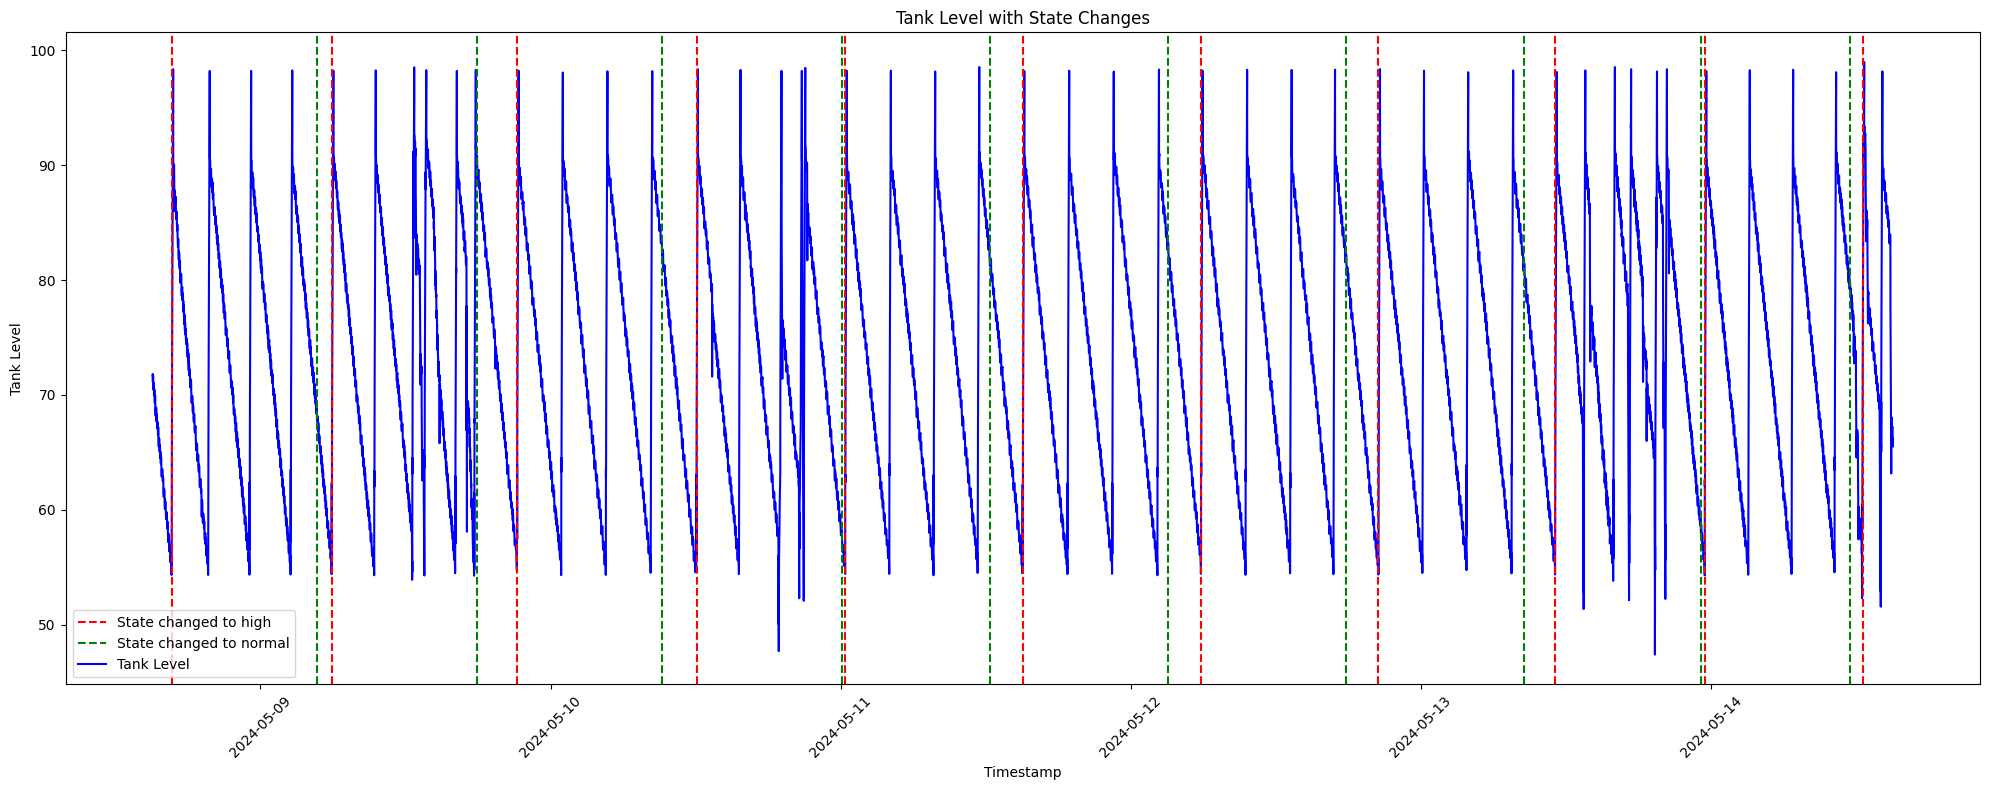

Total state changes: 21
State changed to high at 2024-05-08 16:38:58.513000+00:00
State changed to normal at 2024-05-09 04:39:57.764007+00:00
State changed to high at 2024-05-09 05:54:56.016006+00:00
State changed to normal at 2024-05-09 17:55:31.264007+00:00
State changed to high at 2024-05-09 21:13:15.764007+00:00
State changed to normal at 2024-05-10 09:14:17.014007+00:00
State changed to high at 2024-05-10 12:04:49.264007+00:00
State changed to normal at 2024-05-11 00:06:36.766006+00:00
State changed to high at 2024-05-11 00:22:22.765014+00:00
State changed to normal at 2024-05-11 12:22:40.264007+00:00
State changed to high at 2024-05-11 15:04:52.514007+00:00
State changed to normal at 2024-05-12 03:05:09.764007+00:00
State changed to high at 2024-05-12 05:48:28.264007+00:00
State changed to normal at 2024-05-12 17:50:19.514007+00:00
State changed to high at 2024-05-12 20:29:25.763000+00:00
State changed to normal at 2024-05-13 08:29:31.264007+00:00
State changed to high at 2024-05

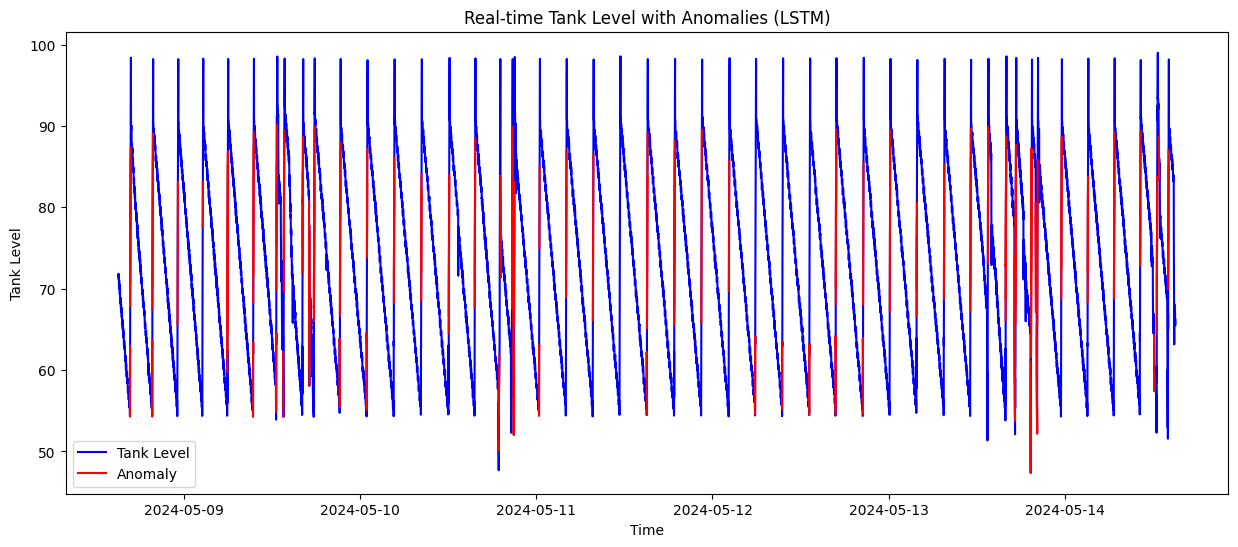

2024-04-18 15:15:12+00
2024-05-08 15:15:12+00
Training started NOW
X_realtime [[57.6375    57.6375    56.9374962 56.29375   56.9500046]
 [57.6375    56.9374962 56.29375   56.9500046 57.09375  ]
 [56.9374962 56.29375   56.9500046 57.09375   57.14375  ]
 ...
 [69.9562454 70.025     70.4375    70.51875   70.3      ]
 [70.025     70.4375    70.51875   70.3       69.73125  ]
 [70.4375    70.51875   70.3       69.73125   69.28125  ]]
Epoch 1/100
804/804 [==============================] - 13s 13ms/step - loss: 103.6131 - val_loss: 0.3994
Epoch 2/100
804/804 [==============================] - 8s 10ms/step - loss: 0.4135 - val_loss: 0.4622
Epoch 3/100
804/804 [==============================] - 10s 12ms/step - loss: 0.3738 - val_loss: 0.3700
Epoch 4/100
804/804 [==============================] - 9s 11ms/step - loss: 0.3178 - val_loss: 0.3223
Epoch 5/100
804/804 [==============================] - 9s 11ms/step - loss: 0.2859 - val_loss: 0.2474
Epoch 6/100
804/804 [==============================] -

In [ ]:
import os
def real_time_monitoring():

    start_time, end_time = generate_query_timestamps(6)

    model_path = 'lstm_model.h5'
    if not os.path.exists(model_path):
        print("Model file not found. Please train the model first.")
        return  # Exit the function if model is not found

    model = tf.keras.models.load_model(model_path)
    print("Model loaded successfully for monitoring.")

    print("hiiiii")
    print(start_time)
    print(end_time)
    state_info = load_state_info()
    current_state = state_info['current_state']
    print("Current State", current_state)
    utc_zone = tz.tzutc()
    last_state_change_time = datetime.strptime(state_info['last_state_change_time'], '%Y-%m-%d %H:%M:%S+00:00')
    print("last_stage_change_time",last_state_change_time)
    now = datetime.now(pytz.utc)
    should_save_state_info = False

    authenticator = "Anish"
    password = "Msdhoni#7ncsu"
    name = "atoorpu"
    role = "ncsu_group"
    instance_graphql_endpoint = "https://ncsu.cesmii.net/graphql"


    graphql_query = f"""
    query HistoryQuery {{
        getRawHistoryDataWithSampling(
            maxSamples: 0
            ids: ["764692","764782"]
            startTime: "{start_time}"
            endTime: "{end_time}"
        ) {{
            ts
            floatvalue
            stringvalue
        }}
    }}
    """

    # Here you would fetch and preprocess your data to get X_realtime
    # For example, let's assume you've done this and have your data ready in X_realtime
    response_data = perform_graphql_request(graphql_query, instance_graphql_endpoint, authenticator, password, name, role)
    print(response_data)


    # Extract data from response
    data = response_data["data"]["getRawHistoryDataWithSampling"]
    print(data)


    stringvalue_dict = preprocess_data(data)



    sequence_length = 5
    X_realtime,pre_df = preprocess_realtime_data(stringvalue_dict, sequence_length)



    print("pre_df",pre_df)
    print(len(pre_df))



    predictions = model.predict(X_realtime)
    predictions = predictions.squeeze(axis=-1)
    print("predictions",predictions)
    if pre_df.index.tzinfo is None or pre_df.index.tzinfo.utcoffset(pre_df.index[0]) is None:
        pre_df.index = pd.to_datetime(pre_df.index).tz_localize(tz.tzutc())
    else:
        pre_df.index = pre_df.index.tz_convert(tz.tzutc())

    # start_time="2024-04-06 12:32:33.513000+00:00"
    # end_time="2024-04-12 12:40:59.514999+00:00"
    pre_df_filtered = pre_df[(pre_df.index >= pd.to_datetime(start_time)) & (pre_df.index <= pd.to_datetime(end_time))]
    print("pre_df_filtered",pre_df_filtered)
    print(len(pre_df_filtered))


    # Include your anomaly detection and state change logic here
    switch_states_realtime = np.array([entry['RO_Skid_Running'] for entry in stringvalue_dict.values()][sequence_length - 1:])
    print(switch_states_realtime)

    reconstruction_errors_realtime = np.mean(np.square(X_realtime - predictions), axis=1)
    print(reconstruction_errors_realtime)

    level_pv_last_values = [sequence[-1] for sequence in X_realtime]

    off_state_errors_adjusted = reconstruction_errors_realtime[(switch_states_realtime == 'Off') & (np.array(level_pv_last_values) < 85)]

    threshold_realtime_adjusted = np.percentile(off_state_errors_adjusted, 95)
    #threshold_realtime_adjusted = adaptive_percentile_threshold(off_state_errors_adjusted, window_size=100, percentile=95)
    print("threshold_realtime_adjusted",threshold_realtime_adjusted)

    anomalies_realtime_adjusted = np.where((reconstruction_errors_realtime > threshold_realtime_adjusted) & (switch_states_realtime == 'Off') & (np.array(level_pv_last_values) < 85))[0]
    print(anomalies_realtime_adjusted)

    filtered_anomalies_realtime_adjusted = filter_anomalies(anomalies_realtime_adjusted)
    last_state_change_time = last_state_change_time.replace(tzinfo=tz.tzutc())
    # Example update of state_info (this should be replaced with your actual logic)
    anomaly_presence_threshold = 2 # Threshold for consecutive anomalies to consider a state change
    persistence_requirement = timedelta(hours=12)  # Required duration for anomalies to persist

    utc_zone = pytz.utc
    utc_now = datetime.now(utc_zone)

    fifteen_minutes_ago = utc_now - timedelta(minutes=15)



    # Initialize variables for state monitoring
    state_changes = []
    current_anomaly_sequence = 0
    print(current_state)


    local_current_state = current_state  # Start with the global state
    local_last_state_change_time = last_state_change_time  # Start with the global last change time


    # Process anomalies and determine state changes
    for i in range(len(pre_df_filtered)):
        is_anomaly = i in filtered_anomalies_realtime_adjusted
        time_since_last_change = pre_df_filtered.index[i] - local_last_state_change_time



        if is_anomaly:
            current_anomaly_sequence += 1
        else:
            current_anomaly_sequence = 0

        state_changed = False
        new_state = None
        if current_anomaly_sequence >= anomaly_presence_threshold and local_current_state == "normal":
            new_state = "high"
            local_current_state = new_state  # Update local state
            local_last_state_change_time = pre_df_filtered.index[i]  # Update local time of change
            state_changes.append((local_last_state_change_time, local_current_state))

        elif not is_anomaly and local_current_state == "high" and time_since_last_change >= persistence_requirement:
            new_state = "normal"
            local_current_state = new_state  # Update local state
            local_last_state_change_time = pre_df_filtered.index[i]  # Update local time of change
            state_changes.append((local_last_state_change_time, local_current_state))


    print("current state", current_state)
    print("state_changes",state_changes)
    recent_state_changes=[]

    # utc_now = datetime.now(pytz.utc)
    # time = "2024-04-12 12:40:59.514999+00:00"
    # utc_now = datetime.strptime(time, '%Y-%m-%d %H:%M:%S.%f%z')
    utc_zone = pytz.utc
    utc_now = datetime.now(utc_zone)
    fifteen_minutes_ago = utc_now - timedelta(minutes=15)
    print("fifteen minutes ago",fifteen_minutes_ago)

    # Filter state changes that occurred within the last 15 minutes
    recent_state_changes = [change for change in state_changes if change[0] >= fifteen_minutes_ago]
    print(recent_state_changes)

    for change_time, new_state in recent_state_changes:
      print(change_time)
      print(new_state)


    # Check if there are any recent changes and process them
    should_save_state_info = False
    for change_time, new_state in recent_state_changes:
        print("new_state",new_state)
        print("current_state",current_state)
        print(new_state != current_state)
        if new_state != current_state:
            # Update the current state and the time of change
            current_state = new_state
            last_state_change_time = change_time
            should_save_state_info = True


            original_plot_buffer, zoomed_plot_buffer = create_plot(pre_df_filtered, state_changes, recent_state_changes)
            original_plot_image = plt.imread(original_plot_buffer)
            zoomed_plot_image = plt.imread(zoomed_plot_buffer)

            # # Display original plot
            # plt.figure(figsize=(20, 8))
            # plt.imshow(original_plot_image)
            # plt.axis('off')
            # plt.title('Original Plot')
            # plt.show()

            # # Display zoomed plot
            # plt.figure(figsize=(20, 8))
            # plt.imshow(zoomed_plot_image)
            # plt.axis('off')
            # plt.title('Zoomed Plot (Last 15 minutes)')
            # plt.show()

            # Prepare and send email about the state change
            subject = f"CESMII SMIP: HPW V8000 State Change Notification: {current_state}"

            est_timezone = pytz.timezone('America/New_York')

            # Convert last_state_change_time to EST and format it
            last_state_change_time_est = last_state_change_time.astimezone(est_timezone).strftime('%Y-%m-%d %H:%M:%S')

            # Customizing the message for each state change
            if new_state == "high":
                message = (f"The HPW system V8000 has entered a state of high water demand as of {last_state_change_time_est}. "
                   "Please change V8000 process setpoints to the following:\n\n"
                   "Return Pressure Setpoint: 44 psig\n"
                   "Supply Pressure Setpoint: 78 psig")
            else:
                message = (f"The HPW system V8000 has entered a normal state with low water usage as of {last_state_change_time_est}. "
                   "Please change V8000 process setpoints to the following:\n\n"
                   "Return Pressure Setpoint: 40 psig\n"
                   "Supply Pressure Setpoint: 64 psig")
            send_email(subject, message, original_plot_buffer, zoomed_plot_buffer)

    if should_save_state_info:
        # Save the state info if there's a recent change
        updated_state_info = {
            "current_state": current_state,
            "last_state_change_time": last_state_change_time.strftime('%Y-%m-%d %H:%M:%S+00:00')
        }
        save_state_info(updated_state_info)
    else:
        # Log a message if no recent changes occurred
        print("No recent changes. Retaining previous state.")

    print("Recent changes within the last 15 minutes:", [f"State changed to {s[1]} at {s[0].strftime('%Y-%m-%d %H:%M:%S+00:00')}" for s in recent_state_changes])

    # plt.figure(figsize=(20, 8))
    # plt.plot(pre_df_filtered.index, pre_df_filtered['Level_PV'], label='Tank Level', color='blue')
    # for change_time, state in state_changes:
    #     plt.axvline(x=change_time, color='red' if state == "high" else 'green', linestyle='--', label=f'State changed to {state}')
    # handles, labels = plt.gca().get_legend_handles_labels()
    # by_label = dict(zip(labels, handles))
    # plt.legend(by_label.values(), by_label.keys())
    # plt.title('Tank Level with State Changes')
    # plt.xlabel('Timestamp')
    # plt.ylabel('Tank Level')
    # plt.xticks(rotation=45)
    # plt.tight_layout()
    # plt.show()


    # # Displaying state changes
    # print(f"Total state changes: {len(state_changes)}")
    # for change_time, state in state_changes:
    #     print(f"State changed to {state} at {change_time}")


    plt.figure(figsize=(20, 8))
    plt.plot(pre_df_filtered.index, pre_df_filtered['Level_PV'], label='Tank Level', color='blue')

    # Plot vertical lines for all state changes
    for change_time, state in state_changes:
        if state == "high":
            color = 'red'
        else:
            color = 'green'
        plt.axvline(x=change_time, color=color, linestyle='--', label=f'State changed to {state}')

    # Highlight recent state changes in purple
    for change_time, state in recent_state_changes:
        plt.axvline(x=change_time, color='purple', linestyle='--', linewidth=6, label='Recent State Change')

    # This part ensures that each state change label is only added to the legend once
    handles, labels = plt.gca().get_legend_handles_labels()
    unique_labels_handles = dict(zip(labels, handles)).items()
    sorted_handles_labels = sorted(unique_labels_handles)  # Sort or customize as needed
    plt.legend([handle for label, handle in sorted_handles_labels], [label for label, handle in sorted_handles_labels])

    plt.title('Tank Level with State Changes')
    plt.xlabel('Timestamp')
    plt.ylabel('Tank Level')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Display the number of state changes
    print(f"Total state changes: {len(state_changes)}")
    for change_time, state in state_changes:
        print(f"State changed to {state} at {change_time}")

    plt.figure(figsize=(15, 6))

    # Plot the tank level
    plt.plot(pre_df_filtered.index, pre_df_filtered['Level_PV'], label='Tank Level', color='blue')

    # Plot the anomalies using plt.plot
    for anomaly in filtered_anomalies_realtime_adjusted:
        anomaly_start_index = anomaly
        anomaly_end_index = anomaly + sequence_length
        # Plot the segment of the anomaly
        plt.plot(pre_df_filtered.index[anomaly_start_index:anomaly_end_index],
                pre_df_filtered['Level_PV'][anomaly_start_index:anomaly_end_index],
                'r-', label='Anomaly' if 'Anomaly' not in [l.get_label() for l in plt.gca().get_lines()] else "")

    plt.legend()
    plt.title('Real-time Tank Level with Anomalies (LSTM)')
    plt.xlabel('Time')
    plt.ylabel('Tank Level')
    plt.show()


# if __name__ == "__main__":
#     real_time_monitoring()
import schedule
import time

# Include all your previous function definitions here, including real_time_monitoring

# Schedule the real_time_monitoring function to run every minute
# schedule.every(15).minutes.do(real_time_monitoring)

if __name__ == "__main__":
    if not os.path.exists('lstm_model.h5'):
        print("No model found. Training now...")
        train_and_save_model()

    # Initial monitoring to start the process
    real_time_monitoring()

    # Set up scheduled tasks
    # schedule.every(30).days.do(train_and_save_model)
    schedule.every(10).minutes.do(train_and_save_model)
    schedule.every(15).minutes.do(real_time_monitoring)

    while True:
        schedule.run_pending()
        time.sleep(1)

In [ ]:
import os
def real_time_monitoring():

    start_time, end_time = generate_query_timestamps(6)

    model_path = 'lstm_model.h5'
    if not os.path.exists(model_path):
        print("Model file not found. Please train the model first.")
        return  # Exit the function if model is not found

    model = tf.keras.models.load_model(model_path)
    print("Model loaded successfully for monitoring.")

    print("hiiiii")
    print(start_time)
    print(end_time)
    state_info = load_state_info()
    current_state = state_info['current_state']
    print("Current State", current_state)
    utc_zone = tz.tzutc()
    last_state_change_time = datetime.strptime(state_info['last_state_change_time'], '%Y-%m-%d %H:%M:%S+00:00')
    print("last_stage_change_time",last_state_change_time)
    now = datetime.now(pytz.utc)
    should_save_state_info = False

    authenticator = "Anish"
    password = "Msdhoni#7ncsu"
    name = "atoorpu"
    role = "ncsu_group"
    instance_graphql_endpoint = "https://ncsu.cesmii.net/graphql"


    graphql_query = f"""
    query HistoryQuery {{
        getRawHistoryDataWithSampling(
            maxSamples: 0
            ids: ["764692","764782"]
            startTime: "{start_time}"
            endTime: "{end_time}"
        ) {{
            ts
            floatvalue
            stringvalue
        }}
    }}
    """

    # Here you would fetch and preprocess your data to get X_realtime
    # For example, let's assume you've done this and have your data ready in X_realtime
    response_data = perform_graphql_request(graphql_query, instance_graphql_endpoint, authenticator, password, name, role)
    print(response_data)


    # Extract data from response
    data = response_data["data"]["getRawHistoryDataWithSampling"]
    print(data)


    stringvalue_dict = preprocess_data(data)



    sequence_length = 5
    X_realtime,pre_df = preprocess_realtime_data(stringvalue_dict, sequence_length)



    print("pre_df",pre_df)
    print(len(pre_df))



    predictions = model.predict(X_realtime)
    predictions = predictions.squeeze(axis=-1)
    print("predictions",predictions)
    if pre_df.index.tzinfo is None or pre_df.index.tzinfo.utcoffset(pre_df.index[0]) is None:
        pre_df.index = pd.to_datetime(pre_df.index).tz_localize(tz.tzutc())
    else:
        pre_df.index = pre_df.index.tz_convert(tz.tzutc())

    # start_time="2024-04-06 12:32:33.513000+00:00"
    # end_time="2024-04-12 12:40:59.514999+00:00"
    pre_df_filtered = pre_df[(pre_df.index >= pd.to_datetime(start_time)) & (pre_df.index <= pd.to_datetime(end_time))]
    print("pre_df_filtered",pre_df_filtered)
    print(len(pre_df_filtered))


    # Include your anomaly detection and state change logic here
    switch_states_realtime = np.array([entry['RO_Skid_Running'] for entry in stringvalue_dict.values()][sequence_length - 1:])
    print(switch_states_realtime)

    reconstruction_errors_realtime = np.mean(np.square(X_realtime - predictions), axis=1)
    anomaly_indices, dynamic_threshold = dynamic_thresholding(reconstruction_errors_realtime, window_size=100, percentile=95)

    print("Dynamic threshold:", dynamic_threshold)
    print("Anomalies detected at indices:", anomaly_indices)

    # Optional: Plot the results for review
    plot_data_with_threshold(pre_df['Level_PV'].values, anomaly_indices, dynamic_threshold)

    print(reconstruction_errors_realtime)

    level_pv_last_values = [sequence[-1] for sequence in X_realtime]

    off_state_errors_adjusted = reconstruction_errors_realtime[(switch_states_realtime == 'Off') & (np.array(level_pv_last_values) < 85)]

    threshold_realtime_adjusted = np.percentile(off_state_errors_adjusted, 95)
    # threshold_realtime_adjusted = adaptive_percentile_threshold(off_state_errors_adjusted, window_size=100, percentile=95)
    print("threshold_realtime_adjusted",threshold_realtime_adjusted)

    anomalies_realtime_adjusted = np.where((reconstruction_errors_realtime > threshold_realtime_adjusted) & (switch_states_realtime == 'Off') & (np.array(level_pv_last_values) < 85))[0]
    print(anomalies_realtime_adjusted)

    filtered_anomalies_realtime_adjusted = filter_anomalies(anomalies_realtime_adjusted)
    last_state_change_time = last_state_change_time.replace(tzinfo=tz.tzutc())
    # Example update of state_info (this should be replaced with your actual logic)
    anomaly_presence_threshold = 2  # Threshold for consecutive anomalies to consider a state change
    persistence_requirement = timedelta(hours=12)  # Required duration for anomalies to persist

    utc_zone = pytz.utc
    utc_now = datetime.now(utc_zone)

    fifteen_minutes_ago = utc_now - timedelta(minutes=15)



    # Initialize variables for state monitoring
    state_changes = []
    current_anomaly_sequence = 0
    print(current_state)


    local_current_state = current_state  # Start with the global state
    local_last_state_change_time = last_state_change_time  # Start with the global last change time


    # Process anomalies and determine state changes
    for i in range(len(pre_df_filtered)):
        is_anomaly = i in filtered_anomalies_realtime_adjusted
        time_since_last_change = pre_df_filtered.index[i] - local_last_state_change_time



        if is_anomaly:
            current_anomaly_sequence += 1
        else:
            current_anomaly_sequence = 0

        state_changed = False
        new_state = None
        if current_anomaly_sequence >= anomaly_presence_threshold and local_current_state == "normal":
            new_state = "high"
            local_current_state = new_state  # Update local state
            local_last_state_change_time = pre_df_filtered.index[i]  # Update local time of change
            state_changes.append((local_last_state_change_time, local_current_state))

        elif not is_anomaly and local_current_state == "high" and time_since_last_change >= persistence_requirement:
            new_state = "normal"
            local_current_state = new_state  # Update local state
            local_last_state_change_time = pre_df_filtered.index[i]  # Update local time of change
            state_changes.append((local_last_state_change_time, local_current_state))

        # if state_changed:
        #     subject = f"State Change Notification: {current_state}"
        #     # Customizing the message for each state change
        #     if new_state == "high":
        #         message = f"Alert: The system state has changed to 'HIGH' as of {last_state_change_time}. Please check the system immediately."
        #     else:
        #         message = f"Info: The system state has reverted to 'NORMAL' as of {last_state_change_time}. System is now functioning within normal parameters."

            #send_email(subject, message)
    print("current state", current_state)
    print("state_changes",state_changes)
    recent_state_changes=[]

    # utc_now = datetime.now(pytz.utc)
    # time = "2024-04-12 12:40:59.514999+00:00"
    # utc_now = datetime.strptime(time, '%Y-%m-%d %H:%M:%S.%f%z')
    utc_zone = pytz.utc
    utc_now = datetime.now(utc_zone)
    fifteen_minutes_ago = utc_now - timedelta(minutes=15)
    print("fifteen minutes ago",fifteen_minutes_ago)

    # Filter state changes that occurred within the last 15 minutes
    recent_state_changes = [change for change in state_changes if change[0] >= fifteen_minutes_ago]
    print(recent_state_changes)

    for change_time, new_state in recent_state_changes:
      print(change_time)
      print(new_state)


    # Check if there are any recent changes and process them
    should_save_state_info = False
    for change_time, new_state in recent_state_changes:
        print("new_state",new_state)
        print("current_state",current_state)
        print(new_state != current_state)
        if new_state != current_state:
            # Update the current state and the time of change
            current_state = new_state
            last_state_change_time = change_time
            should_save_state_info = True


            original_plot_buffer, zoomed_plot_buffer = create_plot(pre_df_filtered, state_changes, recent_state_changes)
            original_plot_image = plt.imread(original_plot_buffer)
            zoomed_plot_image = plt.imread(zoomed_plot_buffer)

            # # Display original plot
            # plt.figure(figsize=(20, 8))
            # plt.imshow(original_plot_image)
            # plt.axis('off')
            # plt.title('Original Plot')
            # plt.show()

            # # Display zoomed plot
            # plt.figure(figsize=(20, 8))
            # plt.imshow(zoomed_plot_image)
            # plt.axis('off')
            # plt.title('Zoomed Plot (Last 15 minutes)')
            # plt.show()

            # Prepare and send email about the state change
            subject = f"CESMII SMIP: HPW V8000 State Change Notification: {current_state}"

            est_timezone = pytz.timezone('America/New_York')

            # Convert last_state_change_time to EST and format it
            last_state_change_time_est = last_state_change_time.astimezone(est_timezone).strftime('%Y-%m-%d %H:%M:%S')

            # Customizing the message for each state change
            if new_state == "high":
                message = (f"The HPW system V8000 has entered a state of high water demand as of {last_state_change_time_est}. "
                   "Please change V8000 process setpoints to the following:\n\n"
                   "Return Pressure Setpoint: 44 psig\n"
                   "Supply Pressure Setpoint: 78 psig")
            else:
                message = (f"The HPW system V8000 has entered a normal state with low water usage as of {last_state_change_time_est}. "
                   "Please change V8000 process setpoints to the following:\n\n"
                   "Return Pressure Setpoint: 40 psig\n"
                   "Supply Pressure Setpoint: 64 psig")
            send_email(subject, message, original_plot_buffer, zoomed_plot_buffer)

    if should_save_state_info:
        # Save the state info if there's a recent change
        updated_state_info = {
            "current_state": current_state,
            "last_state_change_time": last_state_change_time.strftime('%Y-%m-%d %H:%M:%S+00:00')
        }
        save_state_info(updated_state_info)
    else:
        # Log a message if no recent changes occurred
        print("No recent changes. Retaining previous state.")

    print("Recent changes within the last 15 minutes:", [f"State changed to {s[1]} at {s[0].strftime('%Y-%m-%d %H:%M:%S+00:00')}" for s in recent_state_changes])

    # plt.figure(figsize=(20, 8))
    # plt.plot(pre_df_filtered.index, pre_df_filtered['Level_PV'], label='Tank Level', color='blue')
    # for change_time, state in state_changes:
    #     plt.axvline(x=change_time, color='red' if state == "high" else 'green', linestyle='--', label=f'State changed to {state}')
    # handles, labels = plt.gca().get_legend_handles_labels()
    # by_label = dict(zip(labels, handles))
    # plt.legend(by_label.values(), by_label.keys())
    # plt.title('Tank Level with State Changes')
    # plt.xlabel('Timestamp')
    # plt.ylabel('Tank Level')
    # plt.xticks(rotation=45)
    # plt.tight_layout()
    # plt.show()


    # # Displaying state changes
    # print(f"Total state changes: {len(state_changes)}")
    # for change_time, state in state_changes:
    #     print(f"State changed to {state} at {change_time}")


    plt.figure(figsize=(20, 8))
    plt.plot(pre_df_filtered.index, pre_df_filtered['Level_PV'], label='Tank Level', color='blue')

    # Plot vertical lines for all state changes
    for change_time, state in state_changes:
        if state == "high":
            color = 'red'
        else:
            color = 'green'
        plt.axvline(x=change_time, color=color, linestyle='--', label=f'State changed to {state}')

    # Highlight recent state changes in purple
    for change_time, state in recent_state_changes:
        plt.axvline(x=change_time, color='purple', linestyle='--', linewidth=6, label='Recent State Change')

    # This part ensures that each state change label is only added to the legend once
    handles, labels = plt.gca().get_legend_handles_labels()
    unique_labels_handles = dict(zip(labels, handles)).items()
    sorted_handles_labels = sorted(unique_labels_handles)  # Sort or customize as needed
    plt.legend([handle for label, handle in sorted_handles_labels], [label for label, handle in sorted_handles_labels])

    plt.title('Tank Level with State Changes')
    plt.xlabel('Timestamp')
    plt.ylabel('Tank Level')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Display the number of state changes
    print(f"Total state changes: {len(state_changes)}")
    for change_time, state in state_changes:
        print(f"State changed to {state} at {change_time}")

    plt.figure(figsize=(15, 6))

    # Plot the tank level
    plt.plot(pre_df_filtered.index, pre_df_filtered['Level_PV'], label='Tank Level', color='blue')

    # Plot the anomalies using plt.plot
    for anomaly in filtered_anomalies_realtime_adjusted:
        anomaly_start_index = anomaly
        anomaly_end_index = anomaly + sequence_length
        # Plot the segment of the anomaly
        plt.plot(pre_df_filtered.index[anomaly_start_index:anomaly_end_index],
                pre_df_filtered['Level_PV'][anomaly_start_index:anomaly_end_index],
                'r-', label='Anomaly' if 'Anomaly' not in [l.get_label() for l in plt.gca().get_lines()] else "")

    plt.legend()
    plt.title('Real-time Tank Level with Anomalies (LSTM)')
    plt.xlabel('Time')
    plt.ylabel('Tank Level')
    plt.show()


# if __name__ == "__main__":
#     real_time_monitoring()
import schedule
import time

# Include all your previous function definitions here, including real_time_monitoring

# Schedule the real_time_monitoring function to run every minute
# schedule.every(15).minutes.do(real_time_monitoring)

if __name__ == "__main__":
    if not os.path.exists('lstm_model.h5'):
        print("No model found. Training now...")
        train_and_save_model()

    # Initial monitoring to start the process
    real_time_monitoring()

    # Set up scheduled tasks
    # schedule.every(30).days.do(train_and_save_model)
    schedule.every(30).minutes.do(train_and_save_model)
    schedule.every(15).minutes.do(real_time_monitoring)

    while True:
        schedule.run_pending()
        time.sleep(1)

In [ ]:

def real_time_monitoring():
    start_time, end_time = generate_query_timestamps(6)
    print("hiiiii")
    print(start_time)
    print(end_time)
    model = tf.keras.models.load_model('lstm_model1.h5')
    state_info = load_state_info()
    current_state = state_info['current_state']
    print("Current State", current_state)
    utc_zone = tz.tzutc()
    last_state_change_time = datetime.strptime(state_info['last_state_change_time'], '%Y-%m-%d %H:%M:%S+00:00')
    print("last_stage_change_time",last_state_change_time)
    now = datetime.now(pytz.utc)
    should_save_state_info = False

    authenticator = "Anish"
    password = "Msdhoni#7ncsu"
    name = "atoorpu"
    role = "ncsu_group"
    instance_graphql_endpoint = "https://ncsu.cesmii.net/graphql"


    graphql_query = f"""
    query HistoryQuery {{
        getRawHistoryDataWithSampling(
            maxSamples: 0
            ids: ["764692","764782"]
            startTime: "2024-04-06 12:32:33.513000+00:00"
            endTime: "2024-04-12 12:40:59.514999+00:00"
        ) {{
            ts
            floatvalue
            stringvalue
        }}
    }}
    """

    graphql_query_1 = """
    query HistoryQuery {
        getRawHistoryDataWithSampling(
            maxSamples: 0
            ids: ["764692","764782"]
            startTime: "2024-03-20 00:00:00+00"
            endTime: "2024-03-30 00:12:00+00"
        ) {
            ts
            floatvalue
            stringvalue
        }
    }
    """

    # Here you would fetch and preprocess your data to get X_realtime
    # For example, let's assume you've done this and have your data ready in X_realtime
    response_data = perform_graphql_request(graphql_query, instance_graphql_endpoint, authenticator, password, name, role)
    print(response_data)
    response_data_1 = perform_graphql_request(graphql_query_1, instance_graphql_endpoint, authenticator, password, name, role)

    # Extract data from response
    data = response_data["data"]["getRawHistoryDataWithSampling"]
    print(data)
    data_1 = response_data_1["data"]["getRawHistoryDataWithSampling"]

    stringvalue_dict = preprocess_data(data)
    stringvalue_dict_1 = preprocess_data(data_1)


    sequence_length = 5
    X_realtime,pre_df = preprocess_realtime_data(stringvalue_dict, sequence_length)
    X_Train_query,x_df=preprocess_realtime_data(stringvalue_dict_1,sequence_length)


    print("pre_df",pre_df)
    print(len(pre_df))
    print("x_df",x_df)
    print(len(x_df))
    # Plotting or additional processing...
    X = [x_df['Level_PV'].values[i:i + sequence_length] for i in range(len(x_df) - sequence_length)]
    X = np.array(X)
    switch_states = x_df['RO_Skid_Running'].values[sequence_length - 1:]

    # Split the data into training and testing sets
    X_train, X_test, switch_states_train, switch_states_test = train_test_split(
        X, switch_states[:-1], test_size=0.2, shuffle=False
    )



    predictions = model.predict(X_realtime)
    predictions = predictions.squeeze(axis=-1)
    print("predictions",predictions)
    if pre_df.index.tzinfo is None or pre_df.index.tzinfo.utcoffset(pre_df.index[0]) is None:
        pre_df.index = pd.to_datetime(pre_df.index).tz_localize(tz.tzutc())
    else:
        pre_df.index = pre_df.index.tz_convert(tz.tzutc())

    start_time="2024-04-06 12:32:33.513000+00:00"
    end_time="2024-04-12 12:40:59.514999+00:00"
    pre_df_filtered = pre_df[(pre_df.index >= pd.to_datetime(start_time)) & (pre_df.index <= pd.to_datetime(end_time))]
    print("pre_df_filtered",pre_df_filtered)
    print(len(pre_df_filtered))


    # Include your anomaly detection and state change logic here
    switch_states_realtime = np.array([entry['RO_Skid_Running'] for entry in stringvalue_dict.values()][sequence_length - 1:])
    print(switch_states_realtime)

    reconstruction_errors_realtime = np.mean(np.square(X_realtime - predictions), axis=1)
    print(reconstruction_errors_realtime)

    level_pv_last_values = [sequence[-1] for sequence in X_realtime]

    off_state_errors_adjusted = reconstruction_errors_realtime[(switch_states_realtime == 'Off') & (np.array(level_pv_last_values) < 85)]

    threshold_realtime_adjusted = np.percentile(off_state_errors_adjusted, 95)
    print(threshold_realtime_adjusted)

    anomalies_realtime_adjusted = np.where((reconstruction_errors_realtime > threshold_realtime_adjusted) & (switch_states_realtime == 'Off') & (np.array(level_pv_last_values) < 85))[0]
    print(anomalies_realtime_adjusted)

    filtered_anomalies_realtime_adjusted = filter_anomalies(anomalies_realtime_adjusted)
    last_state_change_time = last_state_change_time.replace(tzinfo=tz.tzutc())
    # Example update of state_info (this should be replaced with your actual logic)
    anomaly_presence_threshold = 2  # Threshold for consecutive anomalies to consider a state change
    persistence_requirement = timedelta(hours=10)  # Required duration for anomalies to persist

    utc_zone = pytz.utc
    utc_now = datetime.now(utc_zone)

    fifteen_minutes_ago = utc_now - timedelta(minutes=15)



    # Initialize variables for state monitoring
    state_changes = []
    current_anomaly_sequence = 0
    print(current_state)


    local_current_state = current_state  # Start with the global state
    local_last_state_change_time = last_state_change_time  # Start with the global last change time


    # Process anomalies and determine state changes
    for i in range(len(pre_df_filtered)):
        is_anomaly = i in filtered_anomalies_realtime_adjusted
        time_since_last_change = pre_df_filtered.index[i] - local_last_state_change_time



        if is_anomaly:
            current_anomaly_sequence += 1
        else:
            current_anomaly_sequence = 0

        state_changed = False
        new_state = None
        if current_anomaly_sequence >= anomaly_presence_threshold and local_current_state == "normal":
            new_state = "high"
            local_current_state = new_state  # Update local state
            local_last_state_change_time = pre_df_filtered.index[i]  # Update local time of change
            state_changes.append((local_last_state_change_time, local_current_state))

        elif not is_anomaly and local_current_state == "high" and time_since_last_change >= persistence_requirement:
            new_state = "normal"
            local_current_state = new_state  # Update local state
            local_last_state_change_time = pre_df_filtered.index[i]  # Update local time of change
            state_changes.append((local_last_state_change_time, local_current_state))

        # if state_changed:
        #     subject = f"State Change Notification: {current_state}"
        #     # Customizing the message for each state change
        #     if new_state == "high":
        #         message = f"Alert: The system state has changed to 'HIGH' as of {last_state_change_time}. Please check the system immediately."
        #     else:
        #         message = f"Info: The system state has reverted to 'NORMAL' as of {last_state_change_time}. System is now functioning within normal parameters."

            #send_email(subject, message)
    print("current state", current_state)
    print("state_changes",state_changes)
    recent_state_changes=[]

    # utc_now = datetime.now(pytz.utc)
    time = "2024-04-12 12:40:59.514999+00:00"
    utc_now = datetime.strptime(time, '%Y-%m-%d %H:%M:%S.%f%z')
    fifteen_minutes_ago = utc_now - timedelta(minutes=15)
    print("fifteen minutes ago",fifteen_minutes_ago)

    # Filter state changes that occurred within the last 15 minutes
    recent_state_changes = [change for change in state_changes if change[0] >= fifteen_minutes_ago]
    print(recent_state_changes)

    for change_time, new_state in recent_state_changes:
      print(change_time)
      print(new_state)


    # Check if there are any recent changes and process them
    should_save_state_info = False
    for change_time, new_state in recent_state_changes:
        print("new_state",new_state)
        print("current_state",current_state)
        print(new_state != current_state)
        if new_state != current_state:
            # Update the current state and the time of change
            current_state = new_state
            last_state_change_time = change_time
            should_save_state_info = True

            # # Prepare and send email about the state change
            # subject = f"State Change Notification: {new_state}"
            # message = f"Alert: The system state has changed to '{new_state}' as of {change_time.strftime('%Y-%m-%d %H:%M:%S+00:00')}. Please check the system immediately."
            # send_email(subject, message)
            plot_buffer = create_plot(pre_df_filtered, state_changes, recent_state_changes)

            # Prepare and send email about the state change
            subject = f"CESMII SMIP: HPW V8000 State Change Notification: {current_state}"

            est_timezone = pytz.timezone('America/New_York')

            # Convert last_state_change_time to EST and format it
            last_state_change_time_est = last_state_change_time.astimezone(est_timezone).strftime('%Y-%m-%d %H:%M:%S')

            # Customizing the message for each state change
            if new_state == "high":
                message = (f"The HPW system V8000 has entered a state of high water demand as of {last_state_change_time_est}. "
                   "Please change V8000 process setpoints to the following:\n\n"
                   "Return Pressure Setpoint: 44 psig\n"
                   "Supply Pressure Setpoint: 78 psig")
            else:
                message = (f"The HPW system V8000 has entered a normal state with low water usage as of {last_state_change_time_est}. "
                   "Please change V8000 process setpoints to the following:\n\n"
                   "Return Pressure Setpoint: 40 psig\n"
                   "Supply Pressure Setpoint: 64 psig")
            send_email(subject, message, plot_buffer)




    if should_save_state_info:
        # Save the state info if there's a recent change
        updated_state_info = {
            "current_state": current_state,
            "last_state_change_time": last_state_change_time.strftime('%Y-%m-%d %H:%M:%S+00:00')
        }
        save_state_info(updated_state_info)
    else:
        # Log a message if no recent changes occurred
        print("No recent changes. Retaining previous state.")

    print("Recent changes within the last 15 minutes:", [f"State changed to {s[1]} at {s[0].strftime('%Y-%m-%d %H:%M:%S+00:00')}" for s in recent_state_changes])

    # # Save the updated state
    # state_info = {
    #     "current_state": current_state,
    #     "last_state_change_time": last_state_change_time.strftime('%Y-%m-%d %H:%M:%S+00:00')
    # }
    # save_state_info(state_info)

    # plt.figure(figsize=(20, 8))
    # plt.plot(pre_df_filtered.index, pre_df_filtered['Level_PV'], label='Tank Level', color='blue')
    # for change_time, state in state_changes:
    #     plt.axvline(x=change_time, color='red' if state == "high" else 'green', linestyle='--', label=f'State changed to {state}')
    # handles, labels = plt.gca().get_legend_handles_labels()
    # by_label = dict(zip(labels, handles))
    # plt.legend(by_label.values(), by_label.keys())
    # plt.title('Tank Level with State Changes')
    # plt.xlabel('Timestamp')
    # plt.ylabel('Tank Level')
    # plt.xticks(rotation=45)
    # plt.tight_layout()
    # plt.show()


    # # Displaying state changes
    # print(f"Total state changes: {len(state_changes)}")
    # for change_time, state in state_changes:
    #     print(f"State changed to {state} at {change_time}")


    # plt.figure(figsize=(20, 8))
    # plt.plot(pre_df_filtered.index, pre_df_filtered['Level_PV'], label='Tank Level', color='blue')

    # # Plot vertical lines for all state changes
    # for change_time, state in state_changes:
    #     if state == "high":
    #         color = 'red'
    #     else:
    #         color = 'green'
    #     plt.axvline(x=change_time, color=color, linestyle='--', label=f'State changed to {state}')

    # # Highlight recent state changes in purple
    # for change_time, state in recent_state_changes:
    #     plt.axvline(x=change_time, color='purple', linestyle='--', linewidth=6, label='Recent State Change')

    # # This part ensures that each state change label is only added to the legend once
    # handles, labels = plt.gca().get_legend_handles_labels()
    # unique_labels_handles = dict(zip(labels, handles)).items()
    # sorted_handles_labels = sorted(unique_labels_handles)  # Sort or customize as needed
    # plt.legend([handle for label, handle in sorted_handles_labels], [label for label, handle in sorted_handles_labels])

    # plt.title('Tank Level with State Changes')
    # plt.xlabel('Timestamp')
    # plt.ylabel('Tank Level')
    # plt.xticks(rotation=45)
    # plt.tight_layout()
    # plt.show()

    # Display the number of state changes
    print(f"Total state changes: {len(state_changes)}")
    for change_time, state in state_changes:
        print(f"State changed to {state} at {change_time}")

    plt.figure(figsize=(15, 6))

    # Plot the tank level
    plt.plot(pre_df_filtered.index, pre_df_filtered['Level_PV'], label='Tank Level', color='blue')

    # Plot the anomalies using plt.plot
    for anomaly in filtered_anomalies_realtime_adjusted:
        anomaly_start_index = anomaly
        anomaly_end_index = anomaly + sequence_length
        # Plot the segment of the anomaly
        plt.plot(pre_df_filtered.index[anomaly_start_index:anomaly_end_index],
                pre_df_filtered['Level_PV'][anomaly_start_index:anomaly_end_index],
                'r-', label='Anomaly' if 'Anomaly' not in [l.get_label() for l in plt.gca().get_lines()] else "")

    plt.legend()
    plt.title('Real-time Tank Level with Anomalies (LSTM)')
    plt.xlabel('Time')
    plt.ylabel('Tank Level')
    plt.show()


if __name__ == "__main__":
    real_time_monitoring()
import schedule
import time

# Include all your previous function definitions here, including real_time_monitoring

# Schedule the real_time_monitoring function to run every minute
schedule.every(15).minutes.do(real_time_monitoring)

if __name__ == "__main__":
    real_time_monitoring()  # Direct call to test the function
    schedule.every(15).minutes.do(real_time_monitoring)
    while True:
        schedule.run_pending()
        time.sleep(1)

hiiiii
2024-05-03 06:54:24+00
2024-05-09 06:54:24+00


OSError: No file or directory found at lstm_model1.h5

In [ ]:
def real_time_monitoring():
    start_time, end_time = generate_query_timestamps(6)
    print("hiiiii")
    print(start_time)
    print(end_time)
    model = tf.keras.models.load_model('lstm_model1.h5')
    state_info = load_state_info()
    current_state = state_info['current_state']
    print("Current State", current_state)
    utc_zone = tz.tzutc()
    last_state_change_time = datetime.strptime(state_info['last_state_change_time'], '%Y-%m-%d %H:%M:%S+00:00')
    print("last_stage_change_time",last_state_change_time)
    now = datetime.now(pytz.utc)
    should_save_state_info = False

    authenticator = "Anish"
    password = "Msdhoni#7ncsu"
    name = "atoorpu"
    role = "ncsu_group"
    instance_graphql_endpoint = "https://ncsu.cesmii.net/graphql"


    graphql_query = f"""
    query HistoryQuery {{
        getRawHistoryDataWithSampling(
            maxSamples: 0
            ids: ["764692","764782"]
            startTime: "2024-04-06 12:32:33.513000+00:00"
            endTime: "2024-04-12 12:40:59.514999+00:00"
        ) {{
            ts
            floatvalue
            stringvalue
        }}
    }}
    """

    # graphql_query_1 = """
    # query HistoryQuery {
    #     getRawHistoryDataWithSampling(
    #         maxSamples: 0
    #         ids: ["764692","764782"]
    #         startTime: "2024-03-20 00:00:00+00"
    #         endTime: "2024-03-30 00:12:00+00"
    #     ) {
    #         ts
    #         floatvalue
    #         stringvalue
    #     }
    # }
    # """

    graphql_query_1 = """
    query HistoryQuery {
        getRawHistoryDataWithSampling(
            maxSamples: 0
            ids: ["764692","764782"]
            startTime: "2023-03-20 00:00:00+00"
            endTime: "2023-06-20 00:12:00+00"
        ) {
            ts
            floatvalue
            stringvalue
        }
    }
    """

    # Here you would fetch and preprocess your data to get X_realtime
    # For example, let's assume you've done this and have your data ready in X_realtime
    response_data = perform_graphql_request(graphql_query, instance_graphql_endpoint, authenticator, password, name, role)
    print(response_data)
    response_data_1 = perform_graphql_request(graphql_query_1, instance_graphql_endpoint, authenticator, password, name, role)

    # Extract data from response
    data = response_data["data"]["getRawHistoryDataWithSampling"]
    print(data)
    data_1 = response_data_1["data"]["getRawHistoryDataWithSampling"]

    stringvalue_dict = preprocess_data(data)
    stringvalue_dict_1 = preprocess_data(data_1)


    sequence_length = 5
    X_realtime,pre_df = preprocess_realtime_data(stringvalue_dict, sequence_length)
    X_Train_query,x_df=preprocess_realtime_data(stringvalue_dict_1,sequence_length)


    print("pre_df",pre_df)
    print(len(pre_df))
    print("x_df",x_df)
    print(len(x_df))
    # Plotting or additional processing...
    X = [x_df['Level_PV'].values[i:i + sequence_length] for i in range(len(x_df) - sequence_length)]
    X = np.array(X)
    switch_states = x_df['RO_Skid_Running'].values[sequence_length - 1:]

    # Split the data into training and testing sets
    X_train, X_test, switch_states_train, switch_states_test = train_test_split(
        X, switch_states[:-1], test_size=0.2, shuffle=False
    )



    predictions = model.predict(X_realtime)
    predictions = predictions.squeeze(axis=-1)
    print("predictions",predictions)
    if pre_df.index.tzinfo is None or pre_df.index.tzinfo.utcoffset(pre_df.index[0]) is None:
        pre_df.index = pd.to_datetime(pre_df.index).tz_localize(tz.tzutc())
    else:
        pre_df.index = pre_df.index.tz_convert(tz.tzutc())

    start_time="2024-04-06 12:32:33.513000+00:00"
    end_time="2024-04-12 12:40:59.514999+00:00"
    pre_df_filtered = pre_df[(pre_df.index >= pd.to_datetime(start_time)) & (pre_df.index <= pd.to_datetime(end_time))]
    print("pre_df_filtered",pre_df_filtered)
    print(len(pre_df_filtered))


    # Include your anomaly detection and state change logic here
    switch_states_realtime = np.array([entry['RO_Skid_Running'] for entry in stringvalue_dict.values()][sequence_length - 1:])
    print(switch_states_realtime)

    reconstruction_errors_realtime = np.mean(np.square(X_realtime - predictions), axis=1)
    print(reconstruction_errors_realtime)

    level_pv_last_values = [sequence[-1] for sequence in X_realtime]

    off_state_errors_adjusted = reconstruction_errors_realtime[(switch_states_realtime == 'Off') & (np.array(level_pv_last_values) < 85)]

    threshold_realtime_adjusted = np.percentile(off_state_errors_adjusted, 97)
    print(threshold_realtime_adjusted)

    anomalies_realtime_adjusted = np.where((reconstruction_errors_realtime > threshold_realtime_adjusted) & (switch_states_realtime == 'Off') & (np.array(level_pv_last_values) < 85))[0]
    print(anomalies_realtime_adjusted)

    filtered_anomalies_realtime_adjusted = filter_anomalies(anomalies_realtime_adjusted)
    last_state_change_time = last_state_change_time.replace(tzinfo=tz.tzutc())
    # Example update of state_info (this should be replaced with your actual logic)
    anomaly_presence_threshold = 2  # Threshold for consecutive anomalies to consider a state change
    persistence_requirement = timedelta(hours=10)  # Required duration for anomalies to persist

    utc_zone = pytz.utc
    utc_now = datetime.now(utc_zone)

    fifteen_minutes_ago = utc_now - timedelta(minutes=15)



    # Initialize variables for state monitoring
    state_changes = []
    current_anomaly_sequence = 0
    print(current_state)


    local_current_state = current_state  # Start with the global state
    local_last_state_change_time = last_state_change_time  # Start with the global last change time


    # Process anomalies and determine state changes
    for i in range(len(pre_df_filtered)):
        is_anomaly = i in filtered_anomalies_realtime_adjusted
        time_since_last_change = pre_df_filtered.index[i] - local_last_state_change_time



        if is_anomaly:
            current_anomaly_sequence += 1
        else:
            current_anomaly_sequence = 0

        state_changed = False
        new_state = None
        if current_anomaly_sequence >= anomaly_presence_threshold and local_current_state == "normal":
            new_state = "high"
            local_current_state = new_state  # Update local state
            local_last_state_change_time = pre_df_filtered.index[i]  # Update local time of change
            state_changes.append((local_last_state_change_time, local_current_state))

        elif not is_anomaly and local_current_state == "high" and time_since_last_change >= persistence_requirement:
            new_state = "normal"
            local_current_state = new_state  # Update local state
            local_last_state_change_time = pre_df_filtered.index[i]  # Update local time of change
            state_changes.append((local_last_state_change_time, local_current_state))

        # if state_changed:
        #     subject = f"State Change Notification: {current_state}"
        #     # Customizing the message for each state change
        #     if new_state == "high":
        #         message = f"Alert: The system state has changed to 'HIGH' as of {last_state_change_time}. Please check the system immediately."
        #     else:
        #         message = f"Info: The system state has reverted to 'NORMAL' as of {last_state_change_time}. System is now functioning within normal parameters."

            #send_email(subject, message)
    print("current state", current_state)
    print("state_changes",state_changes)
    recent_state_changes=[]

    # utc_now = datetime.now(pytz.utc)
    time = "2024-04-12 12:40:59.514999+00:00"
    utc_now = datetime.strptime(time, '%Y-%m-%d %H:%M:%S.%f%z')
    fifteen_minutes_ago = utc_now - timedelta(minutes=15)
    print("fifteen minutes ago",fifteen_minutes_ago)

    # Filter state changes that occurred within the last 15 minutes
    recent_state_changes = [change for change in state_changes if change[0] >= fifteen_minutes_ago]
    print(recent_state_changes)

    for change_time, new_state in recent_state_changes:
      print(change_time)
      print(new_state)

    # Check if there are any recent changes and process them
    should_save_state_info = False
    for change_time, new_state in recent_state_changes:
        print("new_state",new_state)
        print("current_state",current_state)
        print(new_state != current_state)
        if new_state != current_state:
            # Update the current state and the time of change
            current_state = new_state
            last_state_change_time = change_time
            should_save_state_info = True

            # Prepare and send email about the state change
            subject = f"State Change Notification: {new_state}"
            message = f"Alert: The system state has changed to '{new_state}' as of {change_time.strftime('%Y-%m-%d %H:%M:%S+00:00')}. Please check the system immediately."
            send_email(subject, message)

    if should_save_state_info:
        # Save the state info if there's a recent change
        updated_state_info = {
            "current_state": current_state,
            "last_state_change_time": last_state_change_time.strftime('%Y-%m-%d %H:%M:%S+00:00')
        }
        save_state_info(updated_state_info)
    else:
        # Log a message if no recent changes occurred
        print("No recent changes. Retaining previous state.")

    print("Recent changes within the last 15 minutes:", [f"State changed to {s[1]} at {s[0].strftime('%Y-%m-%d %H:%M:%S+00:00')}" for s in recent_state_changes])

    # # Save the updated state
    # state_info = {
    #     "current_state": current_state,
    #     "last_state_change_time": last_state_change_time.strftime('%Y-%m-%d %H:%M:%S+00:00')
    # }
    # save_state_info(state_info)

    # plt.figure(figsize=(20, 8))
    # plt.plot(pre_df_filtered.index, pre_df_filtered['Level_PV'], label='Tank Level', color='blue')
    # for change_time, state in state_changes:
    #     plt.axvline(x=change_time, color='red' if state == "high" else 'green', linestyle='--', label=f'State changed to {state}')
    # handles, labels = plt.gca().get_legend_handles_labels()
    # by_label = dict(zip(labels, handles))
    # plt.legend(by_label.values(), by_label.keys())
    # plt.title('Tank Level with State Changes')
    # plt.xlabel('Timestamp')
    # plt.ylabel('Tank Level')
    # plt.xticks(rotation=45)
    # plt.tight_layout()
    # plt.show()


    # # Displaying state changes
    # print(f"Total state changes: {len(state_changes)}")
    # for change_time, state in state_changes:
    #     print(f"State changed to {state} at {change_time}")


    plt.figure(figsize=(20, 8))
    plt.plot(pre_df_filtered.index, pre_df_filtered['Level_PV'], label='Tank Level', color='blue')

    # Plot vertical lines for all state changes
    for change_time, state in state_changes:
        if state == "high":
            color = 'red'
        else:
            color = 'green'
        plt.axvline(x=change_time, color=color, linestyle='--', label=f'State changed to {state}')

    # Highlight recent state changes in purple
    for change_time, state in recent_state_changes:
        plt.axvline(x=change_time, color='purple', linestyle='--', linewidth=6, label='Recent State Change')

    # This part ensures that each state change label is only added to the legend once
    handles, labels = plt.gca().get_legend_handles_labels()
    unique_labels_handles = dict(zip(labels, handles)).items()
    sorted_handles_labels = sorted(unique_labels_handles)  # Sort or customize as needed
    plt.legend([handle for label, handle in sorted_handles_labels], [label for label, handle in sorted_handles_labels])

    plt.title('Tank Level with State Changes')
    plt.xlabel('Timestamp')
    plt.ylabel('Tank Level')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Display the number of state changes
    print(f"Total state changes: {len(state_changes)}")
    for change_time, state in state_changes:
        print(f"State changed to {state} at {change_time}")

    plt.figure(figsize=(15, 6))

    # Plot the tank level
    plt.plot(pre_df_filtered.index, pre_df_filtered['Level_PV'], label='Tank Level', color='blue')

    # Plot the anomalies using plt.plot
    for anomaly in filtered_anomalies_realtime_adjusted:
        anomaly_start_index = anomaly
        anomaly_end_index = anomaly + sequence_length
        # Plot the segment of the anomaly
        plt.plot(pre_df_filtered.index[anomaly_start_index:anomaly_end_index],
                pre_df_filtered['Level_PV'][anomaly_start_index:anomaly_end_index],
                'r-', label='Anomaly' if 'Anomaly' not in [l.get_label() for l in plt.gca().get_lines()] else "")

    plt.legend()
    plt.title('Real-time Tank Level with Anomalies (LSTM)')
    plt.xlabel('Time')
    plt.ylabel('Tank Level')
    plt.show()


if __name__ == "__main__":
    real_time_monitoring()
import schedule
import time

# Include all your previous function definitions here, including real_time_monitoring

# Schedule the real_time_monitoring function to run every minute
schedule.every(15).minutes.do(real_time_monitoring)

if __name__ == "__main__":
    real_time_monitoring()  # Direct call to test the function
    schedule.every(15).minutes.do(real_time_monitoring)
    while True:
        schedule.run_pending()
        time.sleep(1)

hiiiii
2024-04-26 19:52:57+00
2024-05-02 19:52:57+00
Current State normal
last_stage_change_time 2024-05-02 19:52:58
{'data': {'getRawHistoryDataWithSampling': [{'ts': '2024-03-14T00:44:13.007003+00:00', 'floatvalue': None, 'stringvalue': '0'}, {'ts': '2024-04-06T12:31:33.265014+00:00', 'floatvalue': 72.56875, 'stringvalue': None}, {'ts': '2024-04-06T12:33:01.265014+00:00', 'floatvalue': 72.0875, 'stringvalue': None}, {'ts': '2024-04-06T12:33:21.265014+00:00', 'floatvalue': 71.9562454, 'stringvalue': None}, {'ts': '2024-04-06T12:33:31.265014+00:00', 'floatvalue': 72.5125046, 'stringvalue': None}, {'ts': '2024-04-06T12:33:51.265014+00:00', 'floatvalue': 72.625, 'stringvalue': None}, {'ts': '2024-04-06T12:38:59.264999+00:00', 'floatvalue': 72.5187454, 'stringvalue': None}, {'ts': '2024-04-06T12:39:21.264007+00:00', 'floatvalue': 71.7125, 'stringvalue': None}, {'ts': '2024-04-06T12:40:39.264999+00:00', 'floatvalue': 71.025, 'stringvalue': None}, {'ts': '2024-04-06T12:40:53.264007+00:00', 

KeyboardInterrupt: 